In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import glob

# GP's in 2D

Let's look at a GP in 2D and try and get some feel for the benefits and limitations.

We start by reminding ourselfes of the problem in 1D.

We use a squared exponential kernel and the basic linear algebra of GP's which here we implement in numpy.  Previous work has suggested that the numpy implementation is not very stable but it will do for now.

In [2]:
def kernel(x, y, p):
    # p[0] = sigma
    # p[1] = length scale
    return p[0]**2 * np.exp(-0.5 * np.subtract.outer(x, y)**2 / p[1]**2)

In [3]:
def predict(t_2, t_1, kernel, p, y_1):
    B = kernel(t_1, t_2, p).T
    C = kernel(t_2, t_2, p)
    A = kernel(t_1, t_1, p)
    Ainv = np.linalg.inv(A)
    y_pred = np.dot(B, Ainv).dot(y_1)
    sigma_new = C - np.dot(B, Ainv).dot(B.T)
    return y_pred, sigma_new.diagonal()

Now let's make some data.  We'll keep things simple.  
Tanda: here we import frequnecies and inertia a mixed mode identified by n (n_p- n_g) as a function of age. 

In [6]:
#t = np.linspace(-10, 10, 500)
#y = np.sin(t * 1) * np.sin(t / 5)**5
datafile = '/Users/litz/Documents/GitHub/data/sg_simple_grid_mixed_modes/m1.0_feh0.5_MLT1.9_fov0.018.csv'
data = pd.read_csv(datafile)
data.head()

,Unnamed: 0,initial_mass,initial_feh,initial_Z,initial_MLT,initial_ov,model_number,star_age,star_mass,log_dt,...,E_2_31,E_2_32,E_2_33,E_2_34,E_2_35,E_2_36,E_2_37,E_2_38,E_2_39,E_2_40
0,0,1.0,0.5,0.018206,1.9,0.018,1,0.000010,1.0,-5.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,1.0,0.5,0.018206,1.9,0.018,2,0.000022,1.0,-4.920819,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,1.0,0.5,0.018206,1.9,0.018,3,0.000036,1.0,-4.841638,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,1.0,0.5,0.018206,1.9,0.018,4,0.000054,1.0,-4.762456,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,1.0,0.5,0.018206,1.9,0.018,5,0.000074,1.0,-4.683275,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Tanda: we select a mixed mode for l = 1 and n = -50. Note that we only take the frequenceis between 0.4 - 1.6 nu_max because only these frequencies are detectable for the Kepler data. 

In [7]:
mode_l = '1'
mode_n = '-5'

mode_freq = 'nu_'+ mode_l + '_' + mode_n
mode_inertia = 'E_'+ mode_l + '_' + mode_n

sub_df_name = ['initial_mass','initial_feh','star_age','effective_T','nu_max',mode_freq,mode_inertia]
sub_df = data[sub_df_name]
sub_df = sub_df.loc[((sub_df[mode_freq] > 0.4*sub_df['nu_max']) & (sub_df[mode_freq] < 1.6*sub_df['nu_max']))]
sub_df['star_age'] = sub_df['star_age']/1.0e9
sub_df[[mode_freq,mode_inertia]] = np.log10(sub_df[[mode_freq,mode_inertia]])
sub_df.head()

,initial_mass,initial_feh,star_age,effective_T,nu_max,nu_1_-5,E_1_-5
1383,1.0,0.5,11.164973,5281.160862,1020.222560,2.614217,-4.457800
1384,1.0,0.5,11.170401,5273.422111,1015.204139,2.616819,-4.441925
1385,1.0,0.5,11.175739,5265.767034,1010.204598,2.619481,-4.453069
1386,1.0,0.5,11.180993,5258.194229,1005.230871,2.622135,-4.491417
1387,1.0,0.5,11.186168,5250.672674,1000.269440,2.624717,-4.558720


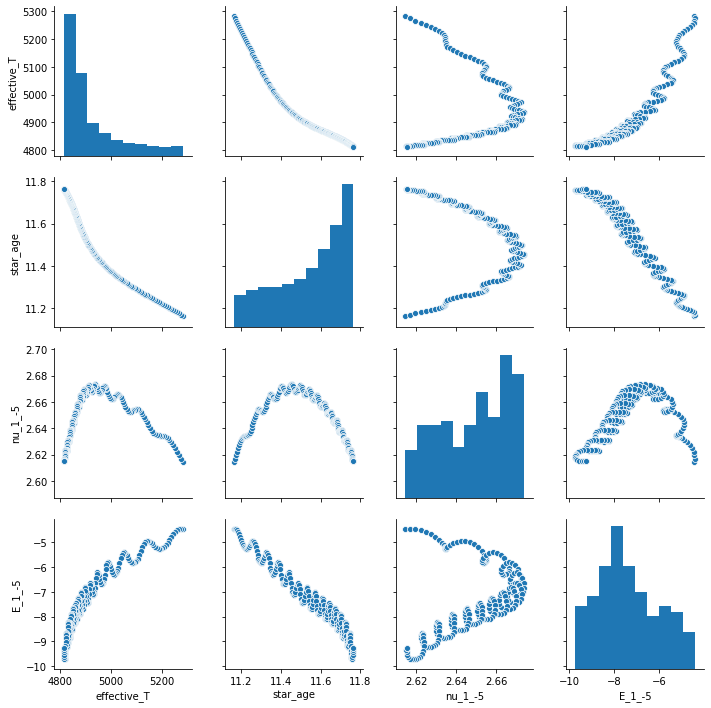

In [8]:
sns.pairplot(sub_df[['effective_T','star_age',mode_freq, mode_inertia]])

Tanda: we normalize the data. 

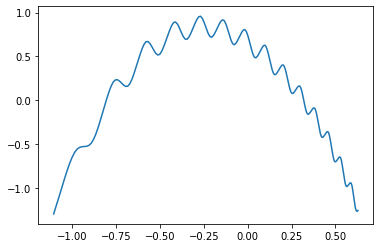

In [9]:
t = sub_df['star_age'].to_numpy()
y = sub_df[mode_freq].to_numpy()
t = (t/np.mean(t) - 1.0)/0.03
y = (y/np.mean(y)-1.0)/0.01
fig, ax = plt.subplots()
ax.plot(t, y)

Now we make the new index points on which we will make a prediction.

We set the kernel parameters to [0.5, 0.008].  This was set by trial and error.

In [10]:
t_2 = np.linspace(min(t), max(t), 20000)
theta = [0.5, 0.008]
#theta = [0.001, 0.009]
y_pred, sigmas = predict(t_2, t, kernel, theta, y)

Now we plot the data and the prediction (but deliberately offset). 

Tanda: The mdoel well predicts the evolution of the mixed modes!

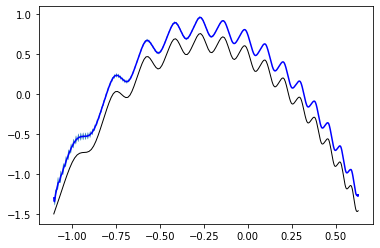

In [11]:
fig, ax = plt.subplots()
ax.plot(t, y-0.2, lw=1, c='k')
ax.fill_between(t_2, y_pred + sigmas, y_pred - sigmas, alpha=0.9)
ax.plot(t_2, y_pred, c = 'b')

We can see the excellent job that the GP is doing here.  Let's make a similar example but in 2D.

# 2D GP

We setup some really simple data

Tanda: here we import more data to see if we can use GP to interpolate in a 2D space, says, mass-age-nu

In [12]:
dr = '/Users/litz/Documents/GitHub/data/sg_simple_grid_mixed_modes/'
files = glob.glob(dr + "*.csv")
temp = []
for filename in files:
    df0 = pd.read_csv(filename, index_col=0)
    temp.append(df0)
data_2d = pd.concat(temp, axis = 0, ignore_index=True)
data_2d['mean_density'] = data_2d['initial_mass']/data_2d['radius']**3.0
data_2d.head()

,initial_mass,initial_feh,initial_Z,initial_MLT,initial_ov,model_number,star_age,star_mass,log_dt,cz_bot_radius,...,E_2_32,E_2_33,E_2_34,E_2_35,E_2_36,E_2_37,E_2_38,E_2_39,E_2_40,mean_density
0,1.43,0.5,0.018206,1.9,0.018,1,0.000010,1.43,-5.000000,7.314822,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000021
1,1.43,0.5,0.018206,1.9,0.018,2,0.000022,1.43,-4.920819,17.256702,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000021
2,1.43,0.5,0.018206,1.9,0.018,3,0.000036,1.43,-4.841638,17.256701,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000021
3,1.43,0.5,0.018206,1.9,0.018,4,0.000054,1.43,-4.762456,17.256700,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000021
4,1.43,0.5,0.018206,1.9,0.018,5,0.000074,1.43,-4.683275,17.256699,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000021


Tanda: we still use the same modes

In [13]:
mode_l = '1'
mode_n = '-5'

mode_freq = 'nu_'+ mode_l + '_' + mode_n
mode_inertia = 'E_'+ mode_l + '_' + mode_n

sub_df_name = ['initial_mass','mean_density','star_age','effective_T','nu_max',mode_freq,mode_inertia]
sub_df = data_2d[sub_df_name]
sub_df = sub_df.loc[((sub_df[mode_freq] > 0.5*sub_df['nu_max']) & (sub_df[mode_freq] < 1.5*sub_df['nu_max']) & (sub_df['initial_mass'] < 1.2) )]
sub_df['star_age'] = sub_df['star_age']/1.0e9
sub_df[[mode_freq,mode_inertia]] = np.log10(sub_df[[mode_freq,mode_inertia]])
sub_df.head()

,initial_mass,mean_density,star_age,effective_T,nu_max,nu_1_-5,E_1_-5
3123,1.19,0.120887,5.766263,5407.468298,827.462247,2.618502,-5.574694
3124,1.19,0.120289,5.769098,5398.908799,825.386398,2.619962,-5.678686
3125,1.19,0.119690,5.771910,5390.417313,823.288911,2.621019,-5.759493
3126,1.19,0.119088,5.774702,5381.990234,821.168795,2.621743,-5.813664
3127,1.19,0.118474,5.777476,5373.524917,818.986905,2.622238,-5.843494


#Tanda: it can be seen that we have different star masses now!
In a 2D data space, age is not suitable to be an input, becasue ages for different masses are quite different.
Intead of the age, effective temperature or mean density looks proper. 

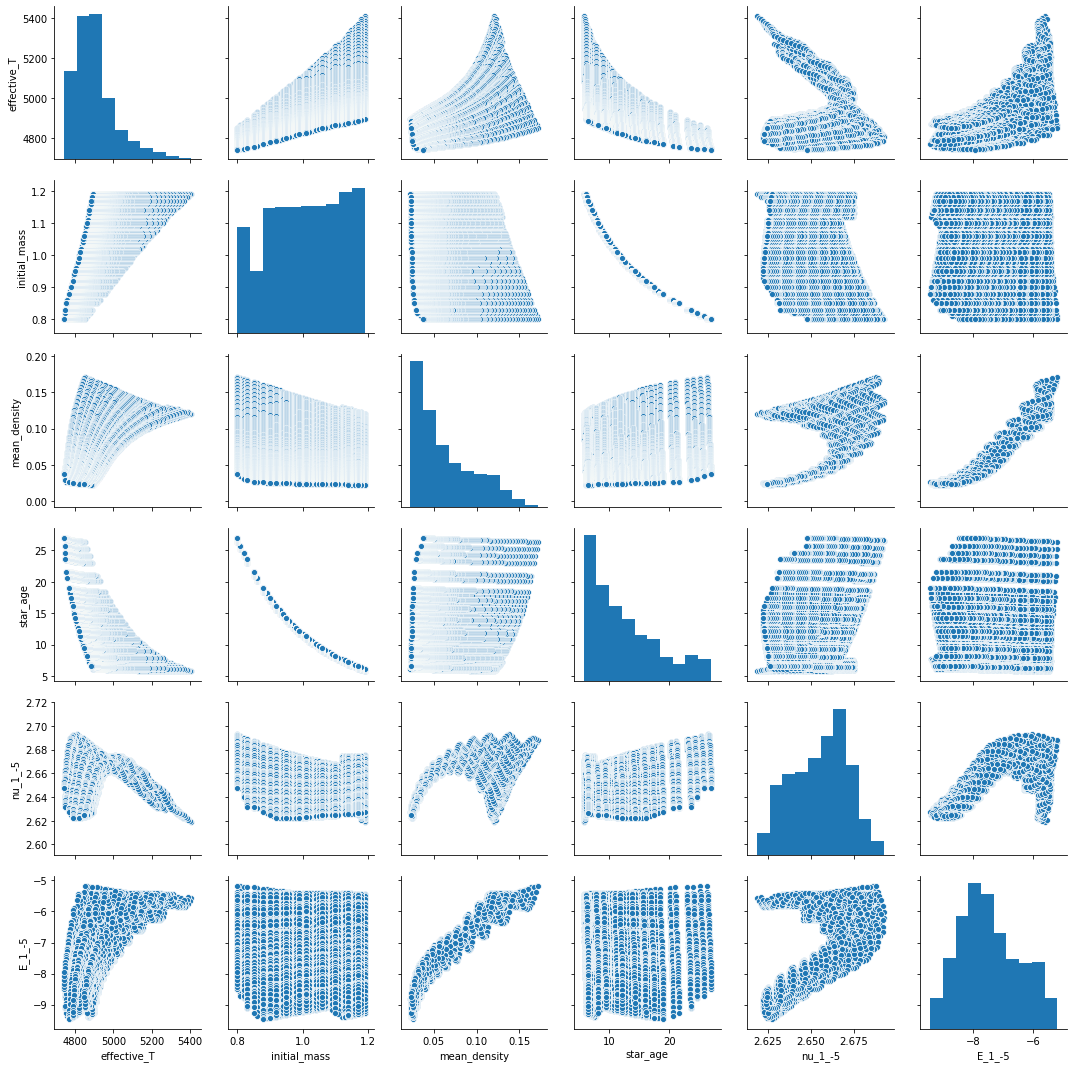

In [14]:
sns.pairplot(sub_df[['effective_T','initial_mass','mean_density','star_age',mode_freq, mode_inertia]])

Here we normalize the data (all data is in a range from -1 to +1)

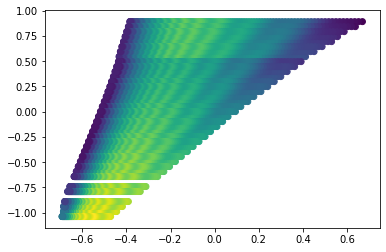

In [23]:
#npts = 50
#x1 = np.linspace(-10, 10, npts)
#x2 = np.linspace(10, -10, npts)
#y = x1 * x2
#fig, ax = plt.subplots()
#ax.scatter(x1, y, c=x2)
mass = sub_df['initial_mass'].to_numpy()
teff = sub_df['effective_T'].to_numpy()
nu = sub_df[mode_freq].to_numpy()
mass_n = (mass/np.median(mass) - 1.0)/0.2
teff_n= (teff/np.median(teff) - 1.0)/0.1 - 0.4
nu_n = (nu/np.mean(nu)-1.0)/0.01
fig, ax = plt.subplots()
ax.scatter(teff_n, mass_n, c=nu_n)

In [24]:
class gp2d():
    def __init__(self, x1, x2, y):
        self.x1 = x1
        self.x2 = x2
        self.y = y
        
    def kernel(self, a1, b1, a2, b2, p):
        ''' Helper funtion really '''
        tmpa = p[0][0]**2 * np.exp(-0.5 * np.subtract.outer(a1, a2)**2 / p[0][1]**2)
        tmpb = p[1][0]**2 * np.exp(-0.5 * np.subtract.outer(b1, b2)**2 / p[1][1]**2)
        return tmpa * tmpb
    
    def predict(self, x1_new, x2_new, p):
        B = self.kernel(self.x1, self.x2, x1_new, x2_new, p).T
        C = self.kernel(x1_new, x2_new, x1_new, x2_new, p)
        A = self.kernel(self.x1, self.x2, self.x1, self.x2, p)
        Ainv = np.linalg.inv(A)
        y_pred = np.dot(B, Ainv).dot(self.y)
        sigma_new = C - np.dot(B, Ainv).dot(B.T)
        return y_pred, sigma_new.diagonal()**0.5

In [25]:
gp = gp2d(teff_n, mass_n, nu_n)
min(mass_n), max(mass_n)

(-1.0396039603960394, 0.8910891089108908)

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in sqrt


(-1, 1)

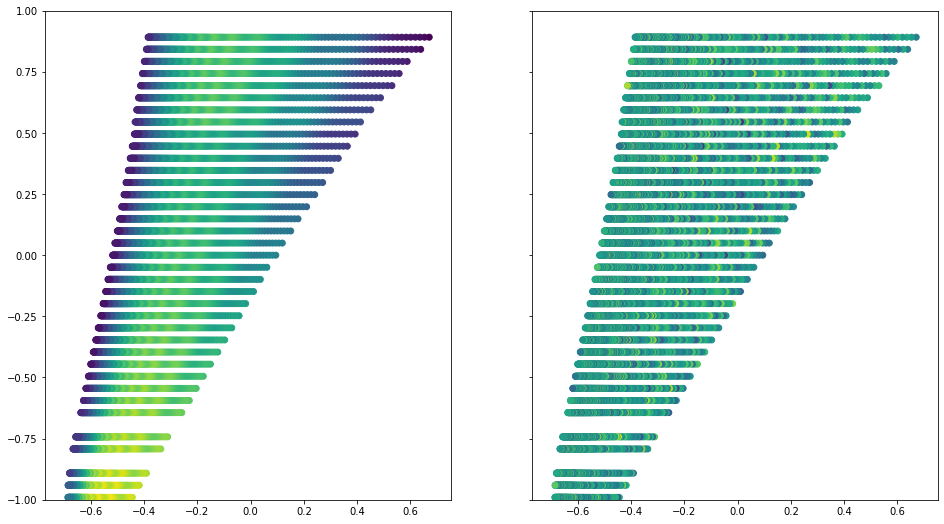

In [54]:

p = [[10, 10], [10, 10]]
mean0, sigma0 = gp.predict(teff_n, mass_n, p)

##cbar = fig.colorbar(cs)
#cbar.ax.set_ylabel('Age (Myr)')
#ax[0].set_xlabel('B-V')
#ax[1].set_xlabel('B-V')
#ax[0].set_ylabel('Period')
#ax[0].set_title('Data')
#ax[1].set_title('GP Inferred relationship')
#fig.savefig('GPyrochronology.png')
teff_new = teff_n

fig, ax = plt.subplots(1, 2, sharey=True, sharex=True, figsize=[16,9])
cs = ax[0].scatter(teff_n, mass_n, c=nu_n)
cs = ax[1].scatter(teff_new, mass_n, c = mean0)
ax[0].set_ylim([-1,1])
ax[1].set_ylim([-1,1])